<a href="https://colab.research.google.com/github/The237/DeepLearningCourses/blob/main/04_CNNs_pour_la_classification_d'Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f"User uploaded file {fn} with length {len(uploaded[fn])} bytes")

Saving salon.png to salon (1).png
User uploaded file salon (1).png with length 239437 bytes


In [9]:
import matplotlib.pyplot as plt

In [15]:
import cv2
import numpy as np

def processImage(image):
  image = cv2.imread(image)
  image = cv2.cvtColor(src=image, code=cv2.COLOR_BGR2GRAY)
  return image


def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

In [16]:
image = processImage("salon.png")

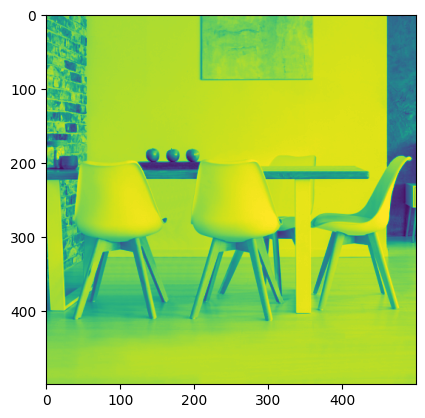

In [17]:
plt.imshow(image)
plt.show()

In [19]:
filtre = np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
])

In [20]:
output = convolve2D(image, filtre, padding = 2)

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0. 169. ... 105.   0.   0.]
 ...
 [  0.   0. 216. ... 220.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


In [24]:
cv2.imwrite("salon_horizontal.png",output)

True

In [34]:
filtre = np.array([
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
])

In [35]:
output = convolve2D(image, filtre, padding = 2)
cv2.imwrite("salon_vertical.png",output)

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0. 169. ... 105.   0.   0.]
 ...
 [  0.   0. 216. ... 220.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]


True

# Test de la convolution sur Fashion MNIST

In [37]:
import tensorflow as tf

data = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = data.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Ici on extrait d'abord des caractéristiques remarquables sur les images à travers les filtres de convolution, avant d'applatir les images comme dans la première méthode.

In [38]:
training_images = training_images/255.0
test_images = test_images/255.0

In [39]:
training_labels = tf.keras.utils.to_categorical(training_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [40]:
training_images.shape

(60000, 28, 28)

On doit reshape l'image afin d'avoir la même structure d'empilement des couches que dans le cas des images couleurs, pour lesquelles on a 3 couches de pixels (RGB) empilées les unes sur les autres.

In [44]:
training_images = training_images.reshape((60_000, 28, 28, 1))
test_images = test_images.reshape((10_000, 28, 28, 1))

In [46]:
training_images.shape, test_images.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

# Modeling

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [65]:
model = Sequential([
    # partie CNN du modèle
    # extraction de caractéristiques
    Conv2D(filters = 64, kernel_size = (3,3), padding="same", activation = "relu", input_shape = (28,28,1)),
    MaxPooling2D(2,2),
    Conv2D(filters = 64, kernel_size = (3,3), padding="same", activation="relu"),
    MaxPooling2D(2,2),

    # applatir les images pour quitter d'un tableau à un vecteur de pixels
    tf.keras.layers.Flatten(),

    # Couches Dense
    Dense(units = 128, activation = "sigmoid"),
    Dense(units = 10, activation = "softmax")
  ]
)

In [66]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 3136)              0         
                                                                 
 dense_6 (Dense)             (None, 128)              

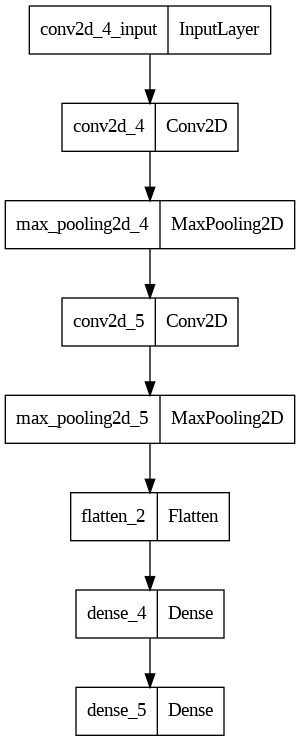

In [59]:
plot_model(model)

In [67]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics = ["accuracy"])

In [68]:
best_model = "best_model.h5"
# permet de sauvegarder le meileur modèle au cours de l'entrainement
model_ckp = ModelCheckpoint(filepath = best_model,
                            monitor = "val_accuracy",
                            mode ="max",
                            save_best_only = True)
# On arrête l'entrainement si après deux époques la performance du modèle n'augmente plus (sur la base de l'accuracy)
# si c'était sur la base du loss (on observerait plutôt la dimunition)
stop = EarlyStopping(monitor = "val_accuracy", patience = 3)

In [70]:
h = model.fit(training_images, training_labels, epochs = 50,
              validation_data = (test_images, test_labels),
              callbacks = [model_ckp, stop])

Epoch 1/50
1875/1875 [==============================] - 80s 43ms/step - loss: 0.3907 - accuracy: 0.8584 - val_loss: 0.3212 - val_accuracy: 0.8828
Epoch 2/50
   3/1875 [..............................] - ETA: 1:08 - loss: 0.2130 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1875/1875 [==============================] - 75s 40ms/step - loss: 0.2689 - accuracy: 0.9026 - val_loss: 0.2789 - val_accuracy: 0.8989
Epoch 3/50
1875/1875 [==============================] - 75s 40ms/step - loss: 0.2233 - accuracy: 0.9178 - val_loss: 0.2506 - val_accuracy: 0.9100
Epoch 4/50
1875/1875 [==============================] - 75s 40ms/step - loss: 0.1941 - accuracy: 0.9280 - val_loss: 0.2382 - val_accuracy: 0.9141
Epoch 5/50
1875/1875 [==============================] - 74s 40ms/step - loss: 0.1682 - accuracy: 0.9371 - val_loss: 0.2241 - val_accuracy: 0.9166
Epoch 6/50
1875/1875 [==============================] - 81s 43ms/step - loss: 0.1442 - accuracy: 0.9474 - val_loss: 0.2405 - val_accuracy: 0.9165
Epoch 7/50
1875/1875 [==============================] - 74s 39ms/step - loss: 0.1257 - accuracy: 0.9537 - val_loss: 0.2365 - val_accuracy: 0.9191
Epoch 8/50
1875/1875 [==============================] - 74s 39ms/step - loss: 0.1090 - accuracy: 0.9607 - val_loss: 0.2322 - val_accura

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_loss_curve(history):
  plt.plot(list(range(len(history["loss"]))), history["loss"], label="Loss")
  plt.plot(list(range(len(history["val_loss"]))), history["val_loss"], label="Val Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss Curve")
  plt.legend()
  plt.show()

def plot_accuracy_curve(history):
  plt.plot(list(range(len(history["accuracy"]))), history["accuracy"], label="Accuracy")
  plt.plot(list(range(len(history["val_accuracy"]))), history["val_accuracy"], label="Val Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Accuracy Curve")
  plt.legend()
  plt.show()

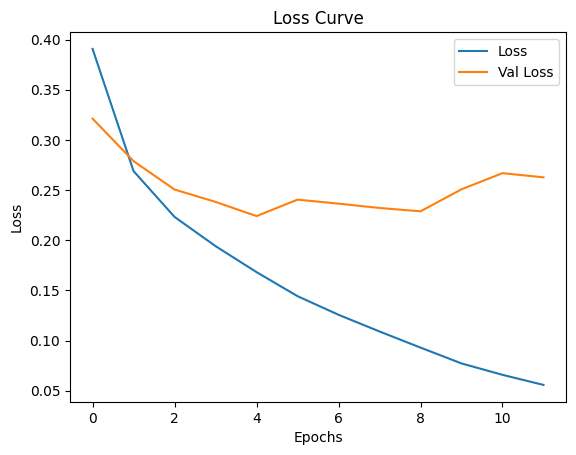

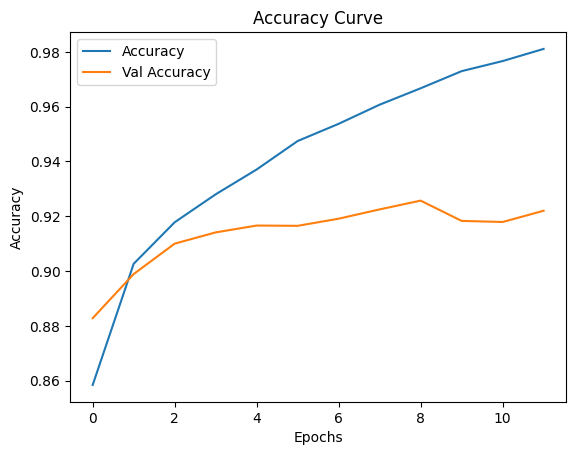

In [72]:
plot_loss_curve(h.history)
plot_accuracy_curve(h.history)

# Projet : Classification d'objets Recyclables ou Non

In [1]:
from google.colab import drive
drive.mount("/gdrive")

Mounted at /gdrive


In [78]:
fichier_archive = "/gdrive/MyDrive/deep_learning_courses/data/WasteDataSet.zip"

In [2]:
!unzip "/gdrive/MyDrive/deep_learning_courses/data/WasteDataSet.zip"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: dataset/DATASET/TRAIN/R/R_5499.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_55.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_550.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5500.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5501.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5502.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5503.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5504.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5505.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5506.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5507.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5508.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5509.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_551.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5510.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5511.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5512.jpg  
  inflating: dataset/DATASET/TRAIN/R/R_5513.jpg  
  inflating: dataset/DATAS

In [3]:
import os

In [4]:
data_dir = "DATASET"

In [5]:
train_dir = os.path.join(data_dir, "TRAIN")
test_dir = os.path.join(data_dir, "TEST")

In [6]:
# path for train directories
train_r_dir = os.path.join(train_dir, "R")
train_o_dir = os.path.join(train_dir, "O")

In [7]:
# path for test directories
test_r_dir = os.path.join(test_dir, "R")
test_o_dir = os.path.join(test_dir, "O")

In [8]:
len(os.listdir(train_o_dir))

12565

# Exploration des données

In [108]:
r_index = 5168
o_index = 1096

recyclable_imgs = [os.path.join(train_r_dir, filename) for filename in os.listdir(train_r_dir)]
organic_imgs = [os.path.join(train_o_dir, filename) for filename in os.listdir(train_o_dir)]

img_r = mpimg.imread(recyclable_imgs[r_index])
img_o = mpimg.imread(recyclable_imgs[o_index])

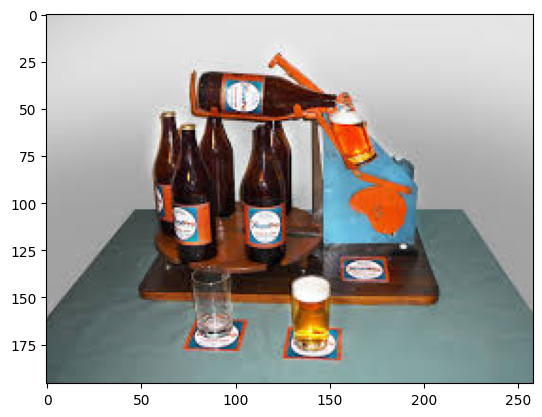

In [109]:
plt.imshow(img_r)
plt.show()

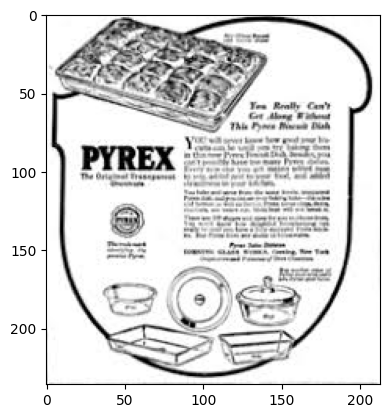

In [110]:
plt.imshow(img_o)
plt.show()

# ImageDataGenerator

In [20]:
from tensorflow.keras.preprocessing.image  import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Flatten

In [11]:
# on divise tous les pixels par 255 pour normaliser
train_data_generator = ImageDataGenerator(rescale = 1/255.0)
test_data_generator = ImageDataGenerator(rescale = 1/255.0)

In [12]:
# on lit les images et on fait en sorte qu'elles aient la même taille
train_generator = train_data_generator.flow_from_directory(
    directory = train_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = "binary"
)

test_generator = test_data_generator.flow_from_directory(
    directory = test_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = "binary"
)

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


In [13]:
batch_images, batch_labels = next(iter(train_generator))

In [14]:
train_generator.class_indices

{'O': 0, 'R': 1}

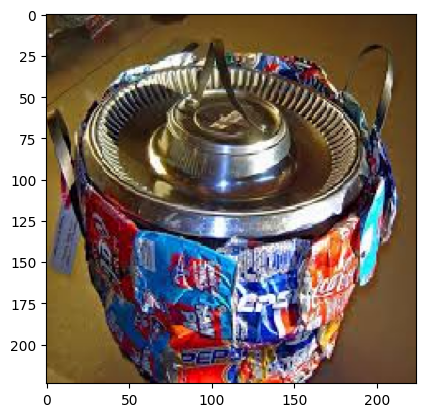

In [17]:
plt.imshow(batch_images[2])

# Modeling

In [21]:
model = Sequential([
    # partie CNN du modèle
    # extraction de caractéristiques
    Conv2D(filters = 32, kernel_size = (3,3), activation = "relu", input_shape = (224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(filters = 64, kernel_size = (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(filters = 128, kernel_size = (3,3), activation="relu"),
    MaxPooling2D(2,2),
    Conv2D(filters = 128, kernel_size = (3,3), activation="relu"),
    MaxPooling2D(2,2),

    # applatir les images pour quitter d'un tableau à un vecteur de pixels
    Flatten(),

    # Couches Dense
    Dense(units = 128, activation = "relu"),
    Dense(units = 1, activation = "sigmoid")
  ]
)


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 128)       0

In [23]:
model.compile(optimizer= RMSprop(learning_rate = .0001),
              loss="binary_crossentropy",
              metrics = ["accuracy"])

In [27]:
best_model = "best_model.h5"
# permet de sauvegarder le meileur modèle au cours de l'entrainement
model_ckp = ModelCheckpoint(filepath = best_model,
                            monitor = "val_accuracy",
                            mode ="max",
                            save_best_only = True)
# On arrête l'entrainement si après deux époques la performance du modèle n'augmente plus (sur la base de l'accuracy)
# si c'était sur la base du loss (on observerait plutôt la dimunition)
stop = EarlyStopping(monitor = "val_accuracy", patience = 6)

h = model.fit(train_generator, epochs = 50, validation_data=test_generator,
              callbacks = [model_ckp,stop])

Epoch 1/50
706/706 [==============================] - 48s 68ms/step - loss: 0.2013 - accuracy: 0.9208 - val_loss: 0.2662 - val_accuracy: 0.9061
Epoch 2/50
706/706 [==============================] - 48s 68ms/step - loss: 0.1827 - accuracy: 0.9279 - val_loss: 0.3178 - val_accuracy: 0.8894
Epoch 3/50
706/706 [==============================] - 48s 68ms/step - loss: 0.1678 - accuracy: 0.9355 - val_loss: 0.3751 - val_accuracy: 0.8774
Epoch 4/50
706/706 [==============================] - 49s 69ms/step - loss: 0.1515 - accuracy: 0.9415 - val_loss: 0.2904 - val_accuracy: 0.9001
Epoch 5/50
706/706 [==============================] - 47s 67ms/step - loss: 0.1343 - accuracy: 0.9509 - val_loss: 0.2973 - val_accuracy: 0.9057
Epoch 6/50
706/706 [==============================] - 47s 66ms/step - loss: 0.1161 - accuracy: 0.9578 - val_loss: 0.2945 - val_accuracy: 0.9097
Epoch 7/50
706/706 [==============================] - 47s 67ms/step - loss: 0.1034 - accuracy: 0.9634 - val_loss: 0.5757 - val_accuracy: